In [1]:
# reading the dataset
import pandas as pd
df = pd.read_csv('C:/Users/subka/Documents/AnacondaProjects/Phishing/dataset/phishing_site_urls.csv')
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [2]:
# shape
df.shape

(549346, 2)

In [3]:
# data preparation
from urllib.parse import urlparse
import tldextract

In [4]:
# map the labels good/bad to 0/1
df['Label'] = df['Label'].map({'good': 0, 'bad': 1})
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1


In [5]:
# feature engineering

# Import necessary libraries
import re
from urllib.parse import urlparse
import tldextract
import numpy as np
import pandas as pd
# Removed unused import: from sklearn.feature_extraction.text import CountVectorizer

# Basic URL structure features
def extract_url_features(df):
    # Length-based features
    df['url_length'] = df['URL'].apply(len)
    df['hostname_length'] = df['URL'].apply(lambda x: len(urlparse(x).netloc))
    df['path_length'] = df['URL'].apply(lambda x: len(urlparse(x).path))
    df['query_length'] = df['URL'].apply(lambda x: len(urlparse(x).query))
    df['fragment_length'] = df['URL'].apply(lambda x: len(urlparse(x).fragment))
    
    # URL components (These are categorical/string features and will be dropped later, but are useful intermediates)
    df['domain'] = df['URL'].apply(lambda x: tldextract.extract(x).domain)
    df['subdomain'] = df['URL'].apply(lambda x: tldextract.extract(x).subdomain)
    df['tld'] = df['URL'].apply(lambda x: tldextract.extract(x).suffix)
    
    # Count-based features
    for symbol in ['-', '@', '?', '%', '.', '=', '/', '_', '&', '!', '*', ',', '//']:
        df[f'count_{symbol}'] = df['URL'].apply(lambda x: x.count(symbol))
    
    # Protocol features
    df['is_https'] = df['URL'].apply(lambda x: 1 if urlparse(x).scheme == 'https' else 0)
    df['has_http'] = df['URL'].apply(lambda x: 1 if 'http://' in x else 0)
    df['has_https'] = df['URL'].apply(lambda x: 1 if 'https://' in x else 0)
    
    return df

# Advanced hostname features
def extract_hostname_features(df):
    # Hostname composition
    df['hostname_digits'] = df['URL'].apply(lambda x: sum(c.isdigit() for c in urlparse(x).netloc))
    df['hostname_letters'] = df['URL'].apply(lambda x: sum(c.isalpha() for c in urlparse(x).netloc))
    df['hostname_digit_ratio'] = df.apply(lambda x: x['hostname_digits'] / x['hostname_length'] if x['hostname_length'] > 0 else 0, axis=1)
    
    # IP address detection (improved regex)
    ip_pattern = r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$"
    df['hostname_is_ip'] = df['URL'].apply(lambda x: 1 if re.match(ip_pattern, urlparse(x).netloc) else 0)
    
    # Subdomain analysis
    df['subdomain_count'] = df['URL'].apply(lambda x: len(tldextract.extract(x).subdomain.split('.')) if tldextract.extract(x).subdomain else 0)
    df['subdomain_length'] = df['URL'].apply(lambda x: len(tldextract.extract(x).subdomain) if tldextract.extract(x).subdomain else 0)
    
    # Domain name entropy (randomness measure)
    def entropy(string):
        prob = [float(string.count(c)) / len(string) for c in set(string)]
        entropy_value = -sum(p * np.log2(p) for p in prob)
        return entropy_value
    
    # Using 'domain' column created in the previous function
    df['domain_entropy'] = df['domain'].apply(lambda x: entropy(x) if x else 0)
    
    return df

# Path and query features
def extract_path_query_features(df):
    # Path analysis
    # FIX APPLIED HERE (removed \n" at the end of the line)
    df['path_tokens'] = df['URL'].apply(lambda x: len(urlparse(x).path.split('/')))
    # FIX APPLIED HERE (removed \n" at the end of the line)
    df['avg_path_token_length'] = df['URL'].apply(
        lambda x: np.mean([len(token) for token in urlparse(x).path.split('/') if token]) if urlparse(x).path else 0
    )
    
    # File extension
    df['has_file_extension'] = df['URL'].apply(lambda x: 1 if re.search(r'\.[a-zA-Z0-9]+$', urlparse(x).path) else 0)
    
    # Common file extensions
    common_extensions = ['.html', '.php', '.aspx', '.jsp', '.js', '.css', '.pdf', '.doc', '.txt']
    for ext in common_extensions:
        df[f'has_{ext[1:]}_extension'] = df['URL'].apply(lambda x: 1 if urlparse(x).path.endswith(ext) else 0)
    
    # Query parameters
    df['query_param_count'] = df['URL'].apply(lambda x: len(urlparse(x).query.split('&')) if urlparse(x).query else 0)
    
    return df

# Security-related features
def extract_security_features(df):
    # Sensitive words detection (expanded list)
    sensitive_words = [
        'secure', 'login', 'signin', 'bank', 'account', 'update', 'verify', 'password',
        'wallet', 'confirm', 'credit', 'debit', 'pay', 'payment', 'ssn', 'social',
        'security', 'credential', 'verify', 'validation', 'authenticate', 'recover',
        'support', 'service', 'official', 'billing', 'authorize', 'reset'
    ]
    
    df['sensitive_word_count'] = df['URL'].apply(
        lambda x: sum(1 for word in sensitive_words if word in x.lower())
    )
    
    # URL shortening services (expanded list)
    shortening_services = [
        'bit.ly', 't.co', 'tinyurl.com', 'goo.gl', 'is.gd', 'cli.gs', 'tr.im',
        'ow.ly', 'tiny.cc', 'cutt.ly', 'shorturl.at', 'buff.ly', 'rebrand.ly',
        'snip.ly', 'clck.ru', 'bitly.com', 'j.mp', 'dlvr.it', 'tny.im'
    ]
    
    df['uses_shortener'] = df['URL'].apply(
        lambda x: 1 if any(service in urlparse(x).netloc for service in shortening_services) else 0
    )
    
    # Suspicious patterns
    # Note: df['subdomain_count'] is calculated in extract_hostname_features, 
    # but since we are applying all functions sequentially, it should exist here.
    df['has_multiple_subdomains'] = df['subdomain_count'].apply(lambda x: 1 if x > 2 else 0)
    df['has_very_long_url'] = df['URL'].apply(lambda x: 1 if len(x) > 100 else 0)
    df['has_hex_chars'] = df['URL'].apply(lambda x: 1 if re.search(r'%[0-9a-fA-F]{2}', x) else 0)
    
    # Brand impersonation detection
    popular_brands = ['google', 'facebook', 'apple', 'microsoft', 'paypal', 'amazon', 'netflix', 'instagram']
    df['brand_impersonation'] = df['URL'].apply(
        lambda x: 1 if any(brand in urlparse(x).netloc.lower() and brand not in tldextract.extract(x).domain.lower() for brand in popular_brands) else 0
    )
    
    return df

# *** FIX: CALL THE FUNCTIONS TO APPLY FEATURES TO THE DATAFRAME ***
df = extract_url_features(df)
df = extract_hostname_features(df)
df = extract_path_query_features(df)
df = extract_security_features(df)

print("Feature engineering complete. DataFrame now contains many new feature columns.")

C:\Users\subka\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\subka\anaconda3\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Feature engineering complete. DataFrame now contains many new feature columns.


In [6]:
# Define features (X) and target (y)
# Drop the original URL and Label, plus the intermediate string columns
columns_to_drop = ['URL', 'Label', 'domain', 'subdomain', 'tld']
feature_columns = df.columns.drop(columns_to_drop, errors='ignore')
X = df[feature_columns]
y = df['Label']

print("X and y defined successfully.")
print("Feature columns:", feature_columns.tolist())
print("X shape:", X.shape)

X and y defined successfully.
Feature columns: ['url_length', 'hostname_length', 'path_length', 'query_length', 'fragment_length', 'count_-', 'count_@', 'count_?', 'count_%', 'count_.', 'count_=', 'count_/', 'count__', 'count_&', 'count_!', 'count_*', 'count_,', 'count_//', 'is_https', 'has_http', 'has_https', 'hostname_digits', 'hostname_letters', 'hostname_digit_ratio', 'hostname_is_ip', 'subdomain_count', 'subdomain_length', 'domain_entropy', 'path_tokens', 'avg_path_token_length', 'has_file_extension', 'has_html_extension', 'has_php_extension', 'has_aspx_extension', 'has_jsp_extension', 'has_js_extension', 'has_css_extension', 'has_pdf_extension', 'has_doc_extension', 'has_txt_extension', 'query_param_count', 'sensitive_word_count', 'uses_shortener', 'has_multiple_subdomains', 'has_very_long_url', 'has_hex_chars', 'brand_impersonation']
X shape: (549346, 47)


In [7]:
from sklearn.model_selection import train_test_split

# This line creates the X_train, X_test, y_train, and y_test variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data successfully split into training and testing sets!")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Data successfully split into training and testing sets!
Shape of X_train: (439476, 47)
Shape of X_test: (109870, 47)


In [8]:
# actual machine learning

from sklearn.ensemble import RandomForestClassifier


print("Training a Random Forest model... (This may take a moment)")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf_model.fit(X_train, y_train)

print("Random Forest training complete")

Training a Random Forest model... (This may take a moment)
Random Forest training complete


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# predictions
print("Making predictions on the test set...")
predictions = rf_model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%\n")


# Precision, recall and F1-Score
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=['Legitimate', 'Phishing']))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

Making predictions on the test set...

Model Accuracy: 92.64%

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.94      0.95      0.95     78670
    Phishing       0.88      0.85      0.87     31200

    accuracy                           0.93    109870
   macro avg       0.91      0.90      0.91    109870
weighted avg       0.93      0.93      0.93    109870


Confusion Matrix:
[[75119  3551]
 [ 4537 26663]]


Generating Confusion Matrix for the Random Forest model...
Saved confusion_matrix_rf.png

Generating ROC Curve for the Random Forest model...
Saved roc_curve_rf.png


<Figure size 800x600 with 0 Axes>

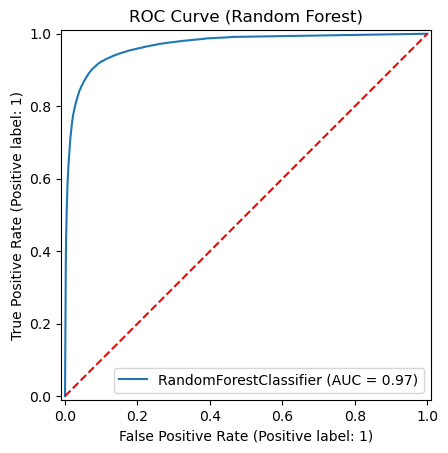

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

predictions = rf_model.predict(X_test)


print("Generating Confusion Matrix for the Random Forest model...")
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_rf.png')
print("Saved confusion_matrix_rf.png")
plt.clf()


print("\nGenerating ROC Curve for the Random Forest model...")

# Use rf_model here instead of model
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title('ROC Curve (Random Forest)')
plt.plot([0, 1], [0, 1], 'r--')
plt.savefig('roc_curve_rf.png')
print("Saved roc_curve_rf.png")

In [11]:
import pandas as pd
import re
from urllib.parse import urlparse
import tldextract
import numpy as np

# --- HELPER FUNCTIONS (RE-CREATED FOR REUSE) ---
# Note: These functions must exactly match the feature creation logic in Cell 44
def get_fd_length(url):
    path = urlparse(url).path
    try:
        return len(path.split('/')[1])
    except IndexError:
        return 0

def engineer_features(df_input):
    df_output = df_input.copy()
    
    # Basic URL structure features
    df_output['url_length'] = df_output['URL'].apply(len)
    df_output['hostname_length'] = df_output['URL'].apply(lambda x: len(urlparse(x).netloc))
    df_output['path_length'] = df_output['URL'].apply(lambda x: len(urlparse(x).path))
    df_output['query_length'] = df_output['URL'].apply(lambda x: len(urlparse(x).query))
    df_output['fragment_length'] = df_output['URL'].apply(lambda x: len(urlparse(x).fragment))
    
    df_output['domain'] = df_output['URL'].apply(lambda x: tldextract.extract(x).domain)
    df_output['subdomain'] = df_output['URL'].apply(lambda x: tldextract.extract(x).subdomain)
    df_output['tld'] = df_output['URL'].apply(lambda x: tldextract.extract(x).suffix)
    
    for symbol in ['-', '@', '?', '%', '.', '=', '/', '_', '&', '!', '*', ',', '//']:
        df_output[f'count_{symbol}'] = df_output['URL'].apply(lambda x: x.count(symbol))
    
    df_output['is_https'] = df_output['URL'].apply(lambda x: 1 if urlparse(x).scheme == 'https' else 0)
    df_output['has_http'] = df_output['URL'].apply(lambda x: 1 if 'http://' in x else 0)
    df_output['has_https'] = df_output['URL'].apply(lambda x: 1 if 'https://' in x else 0)
    
    # Advanced hostname features
    df_output['hostname_digits'] = df_output['URL'].apply(lambda x: sum(c.isdigit() for c in urlparse(x).netloc))
    df_output['hostname_letters'] = df_output['URL'].apply(lambda x: sum(c.isalpha() for c in urlparse(x).netloc))
    df_output['hostname_digit_ratio'] = df_output.apply(lambda x: x['hostname_digits'] / x['hostname_length'] if x['hostname_length'] > 0 else 0, axis=1)
    
    ip_pattern = r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$"
    df_output['hostname_is_ip'] = df_output['URL'].apply(lambda x: 1 if re.match(ip_pattern, urlparse(x).netloc) else 0)
    
    df_output['subdomain_count'] = df_output['URL'].apply(lambda x: len(tldextract.extract(x).subdomain.split('.')) if tldextract.extract(x).subdomain else 0)
    df_output['subdomain_length'] = df_output['URL'].apply(lambda x: len(tldextract.extract(x).subdomain) if tldextract.extract(x).subdomain else 0)
    
    def entropy(string):
        prob = [float(string.count(c)) / len(string) for c in set(string)]
        entropy_value = -sum(p * np.log2(p) for p in prob)
        return entropy_value
    
    df_output['domain_entropy'] = df_output['domain'].apply(lambda x: entropy(x) if x else 0)
    
    # Path and query features
    df_output['path_tokens'] = df_output['URL'].apply(lambda x: len(urlparse(x).path.split('/')))
    df_output['avg_path_token_length'] = df_output['URL'].apply(
        lambda x: np.mean([len(token) for token in urlparse(x).path.split('/') if token]) if urlparse(x).path else 0
    )
    
    df_output['has_file_extension'] = df_output['URL'].apply(lambda x: 1 if re.search(r'\.[a-zA-Z0-9]+$', urlparse(x).path) else 0)
    
    common_extensions = ['.html', '.php', '.aspx', '.jsp', '.js', '.css', '.pdf', '.doc', '.txt']
    for ext in common_extensions:
        df_output[f'has_{ext[1:]}_extension'] = df_output['URL'].apply(lambda x: 1 if urlparse(x).path.endswith(ext) else 0)
    
    df_output['query_param_count'] = df_output['URL'].apply(lambda x: len(urlparse(x).query.split('&')) if urlparse(x).query else 0)
    
    # Security-related features
    sensitive_words = [
        'secure', 'login', 'signin', 'bank', 'account', 'update', 'verify', 'password',
        'wallet', 'confirm', 'credit', 'debit', 'pay', 'payment', 'ssn', 'social',
        'security', 'credential', 'verify', 'validation', 'authenticate', 'recover',
        'support', 'service', 'official', 'billing', 'authorize', 'reset'
    ]
    
    df_output['sensitive_word_count'] = df_output['URL'].apply(
        lambda x: sum(1 for word in sensitive_words if word in x.lower())
    )
    
    shortening_services = [
        'bit.ly', 't.co', 'tinyurl.com', 'goo.gl', 'is.gd', 'cli.gs', 'tr.im',
        'ow.ly', 'tiny.cc', 'cutt.ly', 'shorturl.at', 'buff.ly', 'rebrand.ly',
        'snip.ly', 'clck.ru', 'bitly.com', 'j.mp', 'dlvr.it', 'tny.im'
    ]
    
    df_output['uses_shortener'] = df_output['URL'].apply(
        lambda x: 1 if any(service in urlparse(x).netloc for service in shortening_services) else 0
    )
    
    df_output['has_multiple_subdomains'] = df_output['subdomain_count'].apply(lambda x: 1 if x > 2 else 0)
    df_output['has_very_long_url'] = df_output['URL'].apply(lambda x: 1 if len(x) > 100 else 0)
    df_output['has_hex_chars'] = df_output['URL'].apply(lambda x: 1 if re.search(r'%[0-9a-fA-F]{2}', x) else 0)
    
    popular_brands = ['google', 'facebook', 'apple', 'microsoft', 'paypal', 'amazon', 'netflix', 'instagram']
    df_output['brand_impersonation'] = df_output['URL'].apply(
        lambda x: 1 if any(brand in urlparse(x).netloc.lower() and brand not in tldextract.extract(x).domain.lower() for brand in popular_brands) else 0
    )
    
    # Return features and drop intermediate columns
    return df_output.drop(columns=['URL', 'domain', 'subdomain', 'tld'], errors='ignore')


# --- FINAL PREDICTION FUNCTION (FIXED) ---

def predict_url_with_threshold(url, model, feature_columns, threshold=0.5):
    """
    Takes a URL, processes it, and returns the prediction and confidence score
    using an adjustable threshold.
    """
    test_df = pd.DataFrame([url], columns=['URL'])
    processed_test_df = engineer_features(test_df)
    
    # *** CRITICAL FIX: Use reindex() to enforce the exact column order and fill missing features ***
    # This prevents the feature misalignment that broke the predictions.
    features = processed_test_df.reindex(columns=feature_columns, fill_value=0)
    
    # This addresses the possibility of NaN values from the division-by-zero warnings
    features = features.fillna(0) 

    # Predict using the correctly formatted feature set
    probabilities = model.predict_proba(features)
    phishing_prob = probabilities[0][1] 
    
    prediction = "Phishing" if phishing_prob >= threshold else "Legitimate"
    
    return prediction, phishing_prob

# --- TEST SUITE ---
urls_to_test = [
    "https://www.google.com",                                # Benign
    "https://www.youtube.com/watch?v=dQw4w9WgXcQ",           # Benign
    "http://secure-login-apple-support.com-update.info/",   # Malicious
    "https://amazon.co.uk.security-update.net/verify/",     # Malicious
    "tinyurl.com/bswqloj",                                  # Shortened URL
    "http://192.168.1.1/login.html",                         # IP Address URL
    "https://www.x.com",
    "https://login.nitrkl.ac.in/PortalMain",                 # Benign (Educational login page)
    "https://abc.com"                                        # Benign (Simple short domain)
]

# Use the feature_columns list from the X object created in Cell 45
feature_columns_list = X.columns.tolist()

# Set a custom threshold
custom_threshold = 0.35

print(f"--- Running Final Model Tests with Threshold = {custom_threshold:.0%} ---")

# Loop through the test URLs and print the detailed results
for url in urls_to_test:
    label, confidence = predict_url_with_threshold(url, rf_model, feature_columns_list, threshold=custom_threshold)
    print(f"URL:        {url}")
    print(f"Prediction: {label} (Confidence of Phishing: {confidence:.2%})\n")

--- Running Final Model Tests with Threshold = 35% ---
URL:        https://www.google.com
Prediction: Phishing (Confidence of Phishing: 82.67%)

URL:        https://www.youtube.com/watch?v=dQw4w9WgXcQ
Prediction: Phishing (Confidence of Phishing: 72.00%)

URL:        http://secure-login-apple-support.com-update.info/
Prediction: Phishing (Confidence of Phishing: 77.00%)



C:\Users\subka\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\subka\anaconda3\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


URL:        https://amazon.co.uk.security-update.net/verify/
Prediction: Phishing (Confidence of Phishing: 91.00%)

URL:        tinyurl.com/bswqloj
Prediction: Phishing (Confidence of Phishing: 66.88%)

URL:        http://192.168.1.1/login.html
Prediction: Phishing (Confidence of Phishing: 89.00%)

URL:        https://www.x.com
Prediction: Phishing (Confidence of Phishing: 78.08%)

URL:        https://login.nitrkl.ac.in/PortalMain
Prediction: Phishing (Confidence of Phishing: 68.83%)

URL:        https://abc.com
Prediction: Phishing (Confidence of Phishing: 70.25%)

